# Classifying real vs. fake photons from $t\bar{t}$, $t\bar{t}+\gamma$ events

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from coffea import hist, util
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import uproot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        # data is/isn't Monte-Carlo
        self.isMC = isMC

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")

        photon_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 200)
        photon_eta_axis = hist.Bin("eta","$\eta$", 50, -2, 2)
        photon_phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","pfRelIso03_all", 40, -0.1, 1)
        photon_reliso_chg_axis = hist.Bin("reliso","pfRelIso03_chg", 40, -0.1, 1)
        photon_sieie_axis = hist.Bin("sieie","$\sigma_{i\eta i\eta}$", 40, 0, 0.03)
        photon_r9_axis = hist.Bin("r9","R9", 40, 0.2, 1.2)
        photon_hoe_axis = hist.Bin("hoe","H over E", 40, -0.05, 0.3)
        
        mu_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-muon", 50, 0, 4)
        jet_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-jet", 50, 0, 4)
        
        mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

        flavLabel_axis = hist.Bin("flav",None,[0,1,13,14])
        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",14,0,14)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_mvaid': processor.column_accumulator(np.ndarray(shape=(0,))),
            'file': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis, flavLabel_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis, flavLabel_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis, flavLabel_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis, flavLabel_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis, flavLabel_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis, flavLabel_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis, flavLabel_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis, flavLabel_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, mu_deltar_axis, flavLabel_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, jet_deltar_axis, flavLabel_axis),
            
            'photon_mvaid_hist': hist.Hist("Counts", dataset_axis, mvaid_axis, flavLabel_axis),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4 # tight cut-based ID
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # delta R cuts
        phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
        phoMuMask = ak.fill_none(phoMuDR>0.4,True)
        
        phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
        phoJetMask = ak.fill_none(phoJetDR>0.4,True)
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed) &
                       phoMuMask & phoJetMask
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        # fill histograms
        if self.isMC:
            flavLabel = ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav))
            flavLabel[flavLabel == 13] = 0 # relabel prompt electrons as fake photons
            
            output['photon_pt_hist'].fill(dataset=dataset, flav=flavLabel,
                                          pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
            output['photon_eta_hist'].fill(dataset=dataset, flav=flavLabel,
                                           eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
            output['photon_phi_hist'].fill(dataset=dataset, flav=flavLabel,
                                           phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
            output['photon_reliso_all_hist'].fill(dataset=dataset, flav=flavLabel,
                                                  reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
            output['photon_reliso_chg_hist'].fill(dataset=dataset, flav=flavLabel,
                                                  reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
            output['photon_sieie_hist'].fill(dataset=dataset, flav=flavLabel,
                                             sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
            output['photon_r9_hist'].fill(dataset=dataset, flav=flavLabel,
                                          r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
            output['photon_hoe_hist'].fill(dataset=dataset, flav=flavLabel,
                                           hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
            
            output['deltaR_photon_lepton_hist'].fill(dataset=dataset, flav=flavLabel,
                                                     deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
            output['deltaR_photon_jet_hist'].fill(dataset=dataset, flav=flavLabel,
                                                  deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
            
            output['photon_mvaid_hist'].fill(dataset=dataset, flav=flavLabel,
                                             mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
        
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        
        
        # fill column accumulators
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [3]:
# Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }
filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [4]:
np.warnings.filterwarnings('ignore')

# The NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

# Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

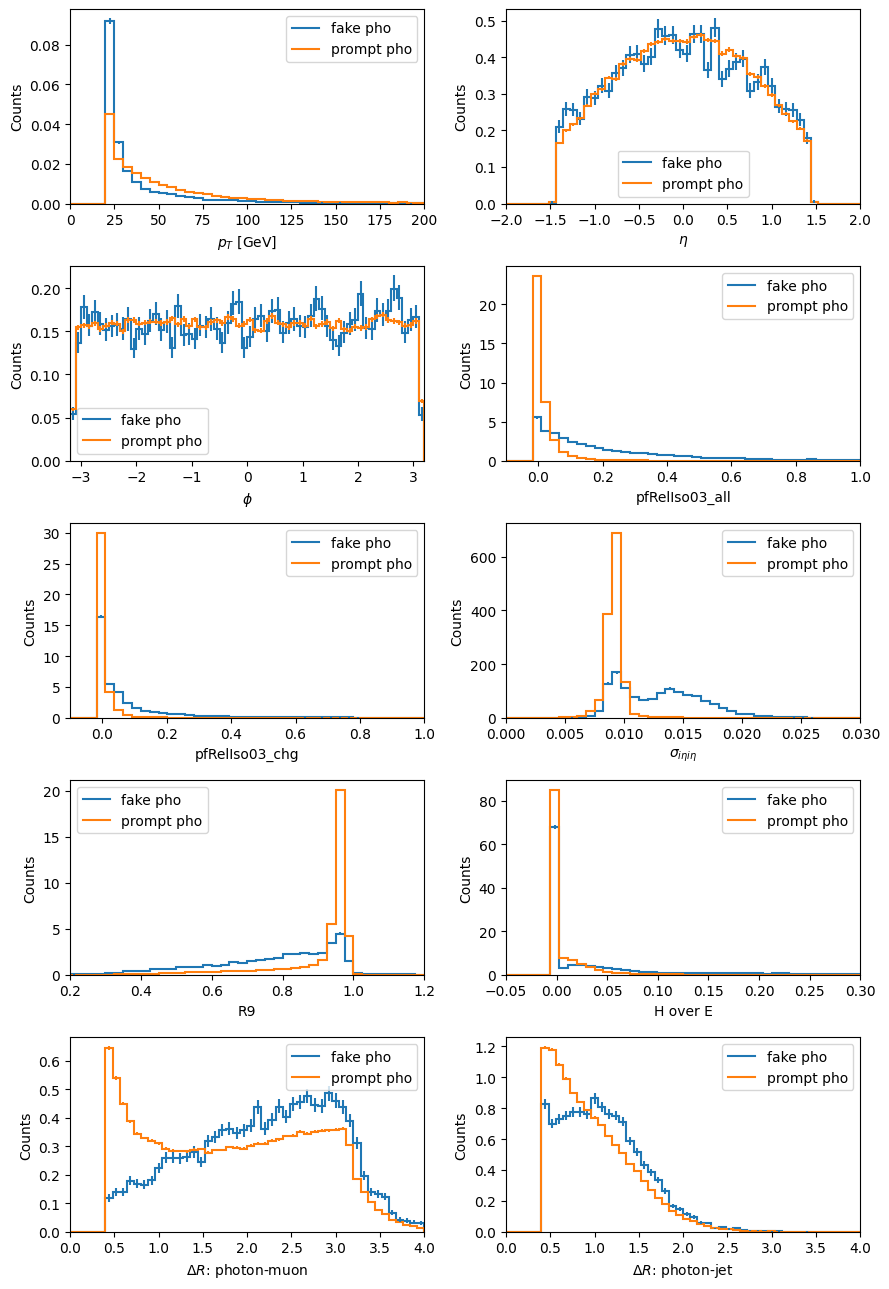

In [5]:
## features ##
fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

legopts = {'labels': ['fake pho','prompt pho']}

hist.plot1d(outputMC['photon_pt_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[0,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_eta_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[0,1],legend_opts=legopts)
hist.plot1d(outputMC['photon_phi_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[1,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_reliso_all_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[1,1],legend_opts=legopts)
hist.plot1d(outputMC['photon_reliso_chg_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[2,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_sieie_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[2,1],legend_opts=legopts)
hist.plot1d(outputMC['photon_r9_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[3,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_hoe_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[3,1],legend_opts=legopts)
hist.plot1d(outputMC['deltaR_photon_lepton_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[4,0],legend_opts=legopts)
hist.plot1d(outputMC['deltaR_photon_jet_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[4,1],legend_opts=legopts)

fig.tight_layout()
plt.show()

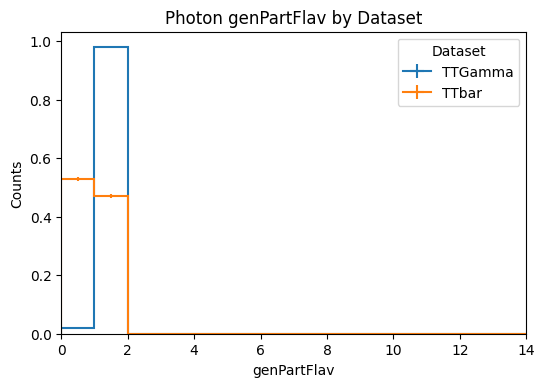

In [6]:
### label ###
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True)
plt.title("Photon genPartFlav by Dataset")
plt.show()

## Preprocessing data for training

In [7]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})

df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
count,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000
mean,59.573669,0.007071,0.009872,0.009389,0.902115,0.009350,0.034985,0.011252,1.866255,0.983235,0.946232
std,58.088821,0.728455,1.812061,0.029659,0.134649,0.001393,0.177741,0.044118,0.925957,0.442693,0.270361
min,20.000051,-1.444092,-3.141602,0.000000,0.172485,0.000196,0.000000,0.000000,0.400002,0.400008,0.000000
25%,25.712778,-0.568115,-1.555664,0.000000,0.906738,0.008850,0.000000,0.000000,1.018647,0.619733,1.000000
50%,39.792137,0.011684,0.004372,0.000000,0.955078,0.009186,0.002177,0.000000,1.887867,0.895582,1.000000
75%,68.434349,0.582764,1.578125,0.005066,0.965820,0.009529,0.023749,0.004598,2.660657,1.258351,1.000000
max,1116.671387,1.444092,3.141602,0.499023,14.820312,0.025925,18.950638,2.312275,4.776289,3.610590,13.000000


In [8]:
df['photon_genPartFlav'].value_counts()

1     165770
0       9738
13        25
Name: photon_genPartFlav, dtype: int64

In [9]:
# relabel 13 (=prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)
df['photon_genPartFlav'].value_counts()

1    165770
0      9763
Name: photon_genPartFlav, dtype: int64

In [10]:
### correlation matrix ###
df.corr()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_genPartFlav
photon_pt,1.000000,0.000206,0.001049,-0.089717,0.131561,-0.067646,-0.071453,-0.093696,0.146190,0.213142,0.083351
photon_eta,0.000206,1.000000,-0.005649,0.000003,0.005371,0.008262,0.001000,-0.002191,-0.006383,-0.001308,0.003685
photon_phi,0.001049,-0.005649,1.000000,0.001886,0.002474,0.002976,0.004607,0.001041,0.002060,0.005943,-0.005154
photon_hoe,-0.089717,0.000003,0.001886,1.000000,-0.112878,0.309488,0.185212,0.209933,0.021403,-0.023634,-0.310302
photon_r9,0.131561,0.005371,0.002474,-0.112878,1.000000,-0.008606,0.077684,-0.071480,-0.003855,0.012655,0.207625
photon_sieie,-0.067646,0.008262,0.002976,0.309488,-0.008606,1.000000,0.320361,0.261351,0.045150,0.028419,-0.624377
photon_pfRelIso03_all,-0.071453,0.001000,0.004607,0.185212,0.077684,0.320361,1.000000,0.427271,0.049315,-0.018860,-0.355288
photon_pfRelIso03_chg,-0.093696,-0.002191,0.001041,0.209933,-0.071480,0.261351,0.427271,1.000000,0.051638,-0.056591,-0.316740
deltaR_photon_lepton,0.146190,-0.006383,0.002060,0.021403,-0.003855,0.045150,0.049315,0.051638,1.000000,0.319260,-0.086520
deltaR_photon_jet,0.213142,-0.001308,0.005943,-0.023634,0.012655,0.028419,-0.018860,-0.056591,0.319260,1.000000,-0.060591


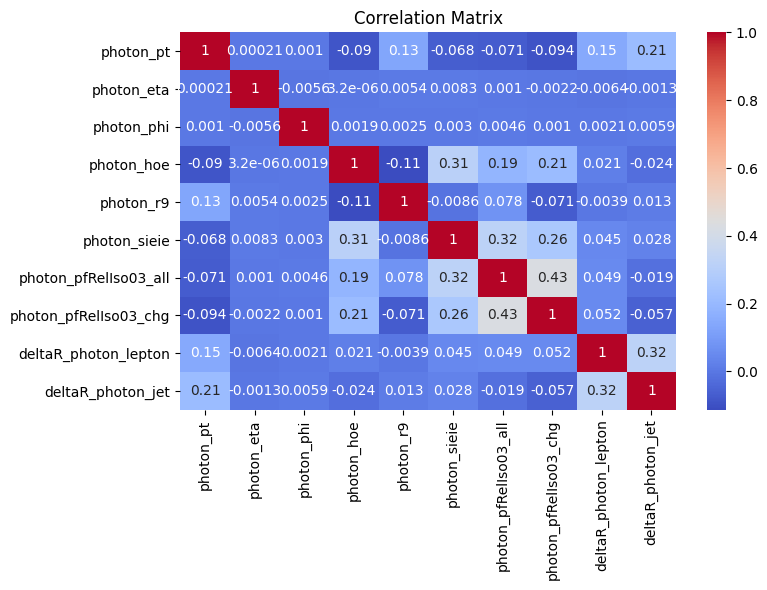

In [11]:
plt.figure(figsize=(8,5),dpi=100)
sns.heatmap(df.drop(['photon_genPartFlav'],axis=1).corr(method='pearson'),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
### split into train, val, test datasets ###

X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [13]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## Build & train model

In [51]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [52]:
callback = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100, batch_size=512, callbacks=[callback])


Epoch 1/100
206/206 [==============================] - 1s 4ms/step - loss: 0.1926 - accuracy: 0.9595 - val_loss: 0.0932 - val_accuracy: 0.9740
Epoch 2/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0888 - accuracy: 0.9745 - val_loss: 0.0878 - val_accuracy: 0.9749
Epoch 3/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0849 - accuracy: 0.9750 - val_loss: 0.0843 - val_accuracy: 0.9751
Epoch 4/100
206/206 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.9756 - val_loss: 0.0828 - val_accuracy: 0.9754
Epoch 5/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0812 - accuracy: 0.9759 - val_loss: 0.0823 - val_accuracy: 0.9756
Epoch 6/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9761 - val_loss: 0.0814 - val_accuracy: 0.9756
Epoch 7/100
206/206 [==============================] - 1s 2ms/step - loss: 0.0798 - accuracy: 0.9761 - val_loss: 0.0808 - val_accuracy: 0.9756

In [53]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.0756
Test accuracy: 0.97704


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


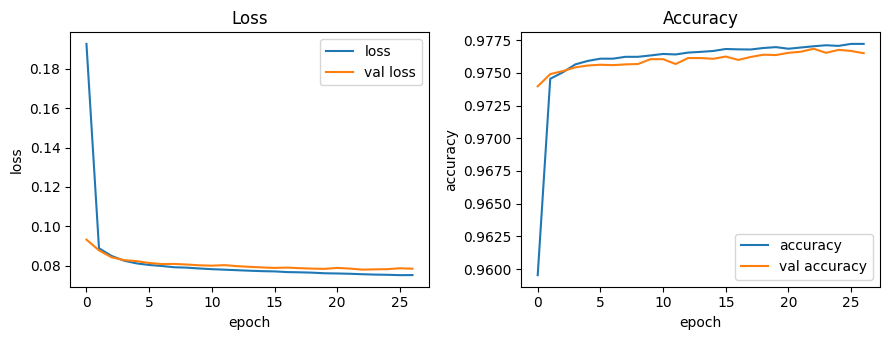

In [54]:
print(history.history.keys())

fig, axs = plt.subplots(1,2,figsize=(9,3.5),dpi=100)

axs[0].plot(history.history['loss'],label="loss")
axs[0].plot(history.history['val_loss'],label="val loss")
axs[1].plot(history.history['accuracy'],label="accuracy")
axs[1].plot(history.history['val_accuracy'],label="val accuracy")

axs[0].set_xlabel('epoch'); axs[0].set_ylabel('loss'); axs[0].set_title('Loss')
axs[1].set_xlabel('epoch'); axs[1].set_ylabel('accuracy'); axs[1].set_title('Accuracy')
axs[0].legend(); axs[1].legend()

plt.tight_layout()
plt.show()

In [55]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

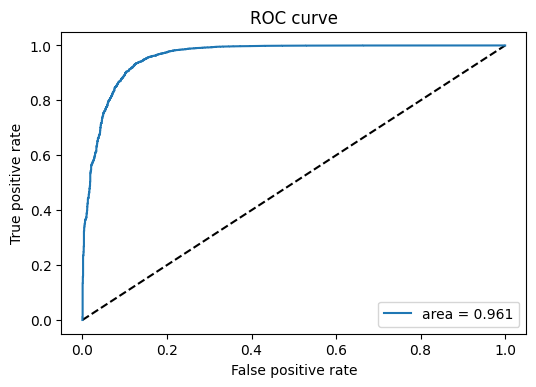

In [56]:
### ROC curve ###

plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [57]:
### prediction distribution ###

predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

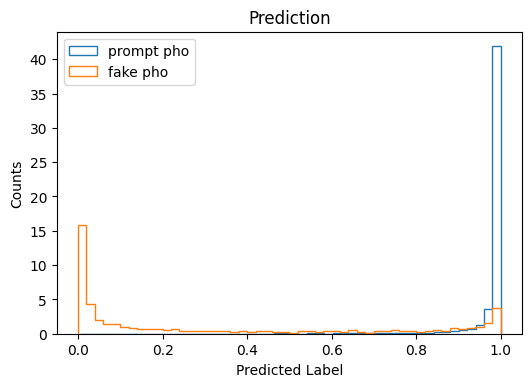

In [58]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predTrue,bins=50,density=True,label='prompt pho',histtype='step')
plt.hist(predFalse,bins=50,density=True,label='fake pho',histtype='step')

plt.xlabel('Predicted Label')
plt.ylabel('Counts')
plt.title('Prediction')
plt.legend(loc='upper left')
plt.show()

In [59]:
### correlation matrix ###

X_test['prediction'] = y_pred
X_test.corr()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,target
photon_pt,1.000000,-0.002682,0.002176,-0.083544,0.135679,-0.069473,-0.078748,-0.090322,0.150348,0.219513,0.099631,0.084783
photon_eta,-0.002682,1.000000,-0.009164,0.002458,0.011109,0.012506,0.013894,0.007459,-0.010156,-0.012605,-0.013565,0.005729
photon_phi,0.002176,-0.009164,1.000000,0.004364,0.001324,0.003193,0.001500,0.004035,0.011944,0.014142,-0.008655,-0.011570
photon_hoe,-0.083544,0.002458,0.004364,1.000000,-0.112906,0.301671,0.197836,0.178279,0.021013,-0.021202,-0.382230,-0.308484
photon_r9,0.135679,0.011109,0.001324,-0.112906,1.000000,-0.006137,0.026381,-0.076620,-0.000029,0.013205,0.250038,0.214486
photon_sieie,-0.069473,0.012506,0.003193,0.301671,-0.006137,1.000000,0.355033,0.254209,0.046020,0.023259,-0.772519,-0.624125
photon_pfRelIso03_all,-0.078748,0.013894,0.001500,0.197836,0.026381,0.355033,1.000000,0.475593,0.052939,-0.029552,-0.506070,-0.396856
photon_pfRelIso03_chg,-0.090322,0.007459,0.004035,0.178279,-0.076620,0.254209,0.475593,1.000000,0.053834,-0.057269,-0.389947,-0.299858
deltaR_photon_lepton,0.150348,-0.010156,0.011944,0.021013,-0.000029,0.046020,0.052939,0.053834,1.000000,0.323572,-0.106749,-0.089335
deltaR_photon_jet,0.219513,-0.012605,0.014142,-0.021202,0.013205,0.023259,-0.029552,-0.057269,0.323572,1.000000,-0.066158,-0.061436


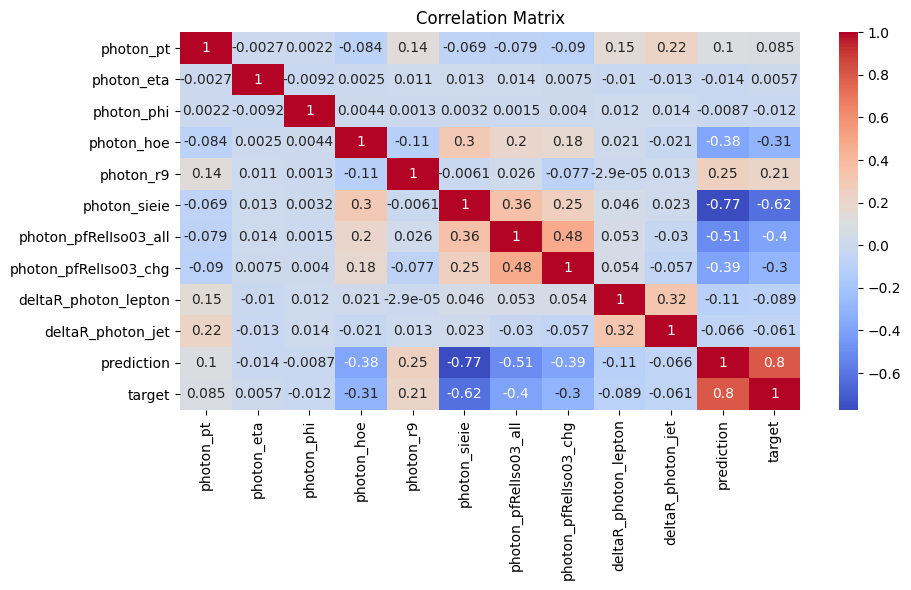

In [60]:
plt.figure(figsize=(10,5),dpi=100)
sns.heatmap(X_test.corr(method='pearson'),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Evaluate the model on data

In [61]:
X_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})

X_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,52.356056,-0.044832,0.072516,0.017655,0.851021,0.010832,0.165943,0.041700,2.082007,1.039004
std,44.367550,0.745467,1.903635,0.049518,0.285727,0.003040,0.449675,0.123595,0.907346,0.467483
min,20.195528,-1.414795,-3.038086,0.000000,0.287842,0.006866,0.000000,0.000000,0.405593,0.407462
25%,23.336668,-0.622070,-1.538574,0.000000,0.737793,0.008942,0.000000,0.000000,1.362517,0.635844
50%,35.041878,-0.029804,-0.127930,0.000000,0.911133,0.009369,0.025838,0.000153,2.180455,0.971324
75%,62.303696,0.484802,1.781738,0.003136,0.962402,0.012047,0.141506,0.028607,2.800998,1.358855
max,297.663422,1.439697,3.133789,0.314453,4.050781,0.023056,4.619414,1.231754,4.449972,2.619408


In [62]:
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

In [63]:
y_pred_data = model.predict(X_data_scaled)

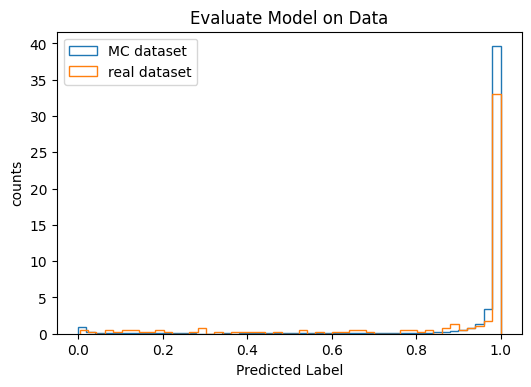

In [64]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(y_pred,bins=50,density=True,label="MC dataset",histtype='step')
plt.hist(y_pred_data,bins=50,density=True,label="real dataset",histtype='step')

plt.xlabel("Predicted Label")
plt.ylabel("counts")
plt.title("Evaluate Model on Data")
plt.legend(loc='upper left')
plt.show()

### Compare to MVA ID

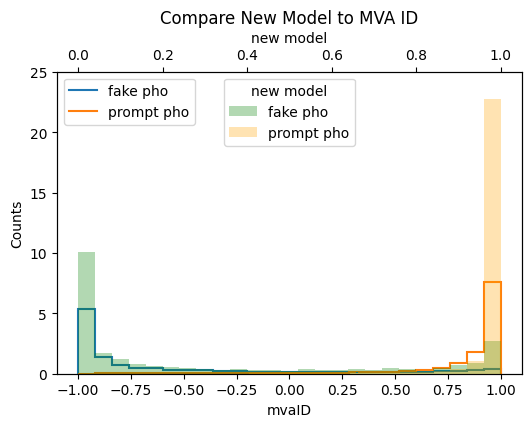

In [65]:
fig, ax1 = plt.subplots(figsize=(6,4),dpi=100)

MC_legend_opts = {'loc':'upper left', 'labels': ['fake pho','prompt pho']}
hist.plot1d(outputMC['photon_mvaid_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=ax1,legend_opts=MC_legend_opts)
ax1.set_xlim(-1.1,1.1)

ax2 = ax1.twiny()
plt.hist(predFalse,bins=25,alpha=0.3,density=True,label='fake pho',color="green")
plt.hist(predTrue,bins=25,alpha=0.3,density=True,label='prompt pho',color="orange")
ax2.set_xlabel("new model")

plt.ylim(0,25)
plt.legend(loc='upper center',title='new model')
plt.title("Compare New Model to MVA ID")
plt.show()

### Incorrectly-classified fake photons

In [66]:
X_test['target'] = y_test
X_test.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,target
8516,30.463993,0.880859,-1.915527,0.0,0.949219,0.010048,0.018221,0.007790,0.777518,0.776676,0.989636,1
102009,94.219284,-0.369934,1.111084,0.0,0.953125,0.010170,0.005113,0.000000,1.756086,1.721098,0.992965,1
150294,35.572186,0.451965,-2.906738,0.0,0.677734,0.008987,0.014813,0.000000,1.577970,1.222363,0.969255,1
151346,28.033655,0.118546,-1.927979,0.0,0.973145,0.009613,0.000391,0.000391,3.076556,0.754890,0.997159,1
86352,36.612545,0.598633,0.985962,0.0,0.967285,0.009254,0.000000,0.000000,1.333299,1.288000,0.996869,1


In [67]:
# incorrectly-classified fake photons:
# target = 0, prediction > 0.5

falsePos = X_test[(X_test['target'] == 0) & (X_test['prediction'] > 0.5)]
trueNeg = X_test[(X_test['target'] == 0) & (X_test['prediction'] < 0.5)]
truePos = X_test[(X_test['target'] == 1) & (X_test['prediction'] > 0.5)]

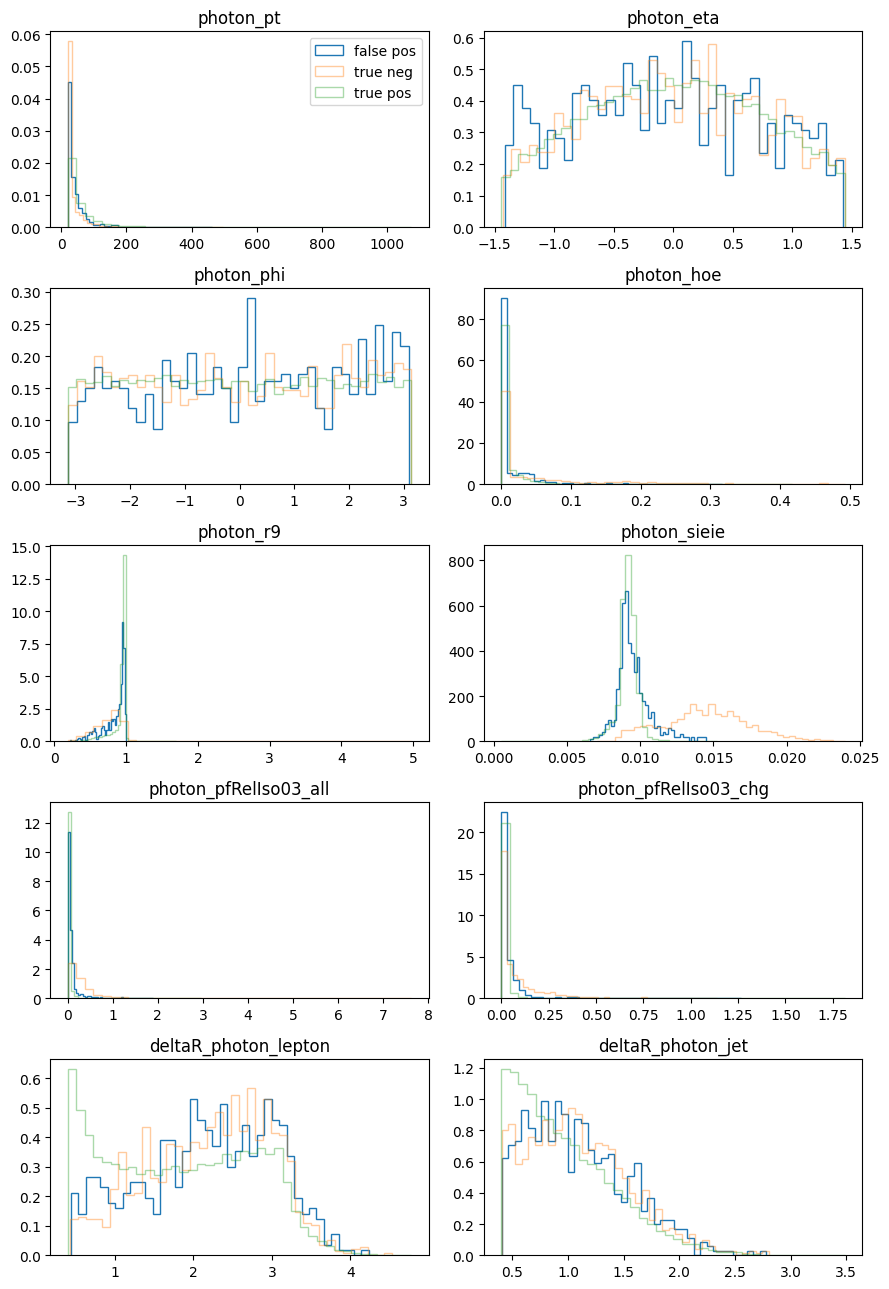

In [68]:
### compare features ###

fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(falsePos[falsePos.keys()[feat]],bins=40,histtype="step",density=True,label="false pos")
        axs[row,col].hist(trueNeg[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.4,density=True,label="true neg")
        axs[row,col].hist(truePos[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.4,density=True,label="true pos")
        axs[0,0].legend(loc="best")
        axs[row,col].set_title(falsePos.keys()[feat])
        feat = feat+1

fig.tight_layout()
plt.show()

# falsePos = incorrectly classified fake photons
# trueNeg = correctly classified fake photons (expected to look different from falsePos)
# truePos = correctly classified prompt photons (expected to look like falsePos)

### Plot ROC curve manually

In [69]:
FPR = []
TPR = []

thresholds = np.linspace(0,1,num=201)

# number of positive (P) and negative (N) samples
P = X_test.target.sum()
N = len(X_test.target) - P

# determine number of true pos & false pos samples for each threshold
for thresh in thresholds:
    FP = 0
    TP = 0
    
    pos = X_test[X_test.prediction>=thresh]
    
    TP = pos.target.sum()
    FP = len(pos.target) - TP
    
    FPR.append(FP/N)
    TPR.append(TP/P)

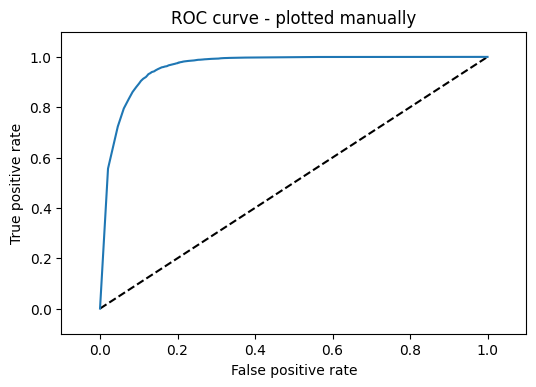

In [70]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(FPR, TPR)

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - plotted manually')
plt.show()